# XGBoost Modeling for Employee Attrition

This notebook implements an end-to-end workflow for predicting employee attrition using XGBoost, including feature engineering, model training, evaluation, and interpretability.

---

## Imports

We begin by importing essential libraries for data manipulation, visualization, and evaluation.

In [456]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap

## Data Loading

Load the cleaned HR employee attrition dataset for modeling. 

In [457]:
# Load the dataset
file_path = '../resources/data/output/hr_employee_attrition_prepared.csv'
df = pd.read_csv(file_path)

In [458]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


## Functions

The following helper functions are used for model evaluation and visualization:
- **plot_roc_curve**: Plots ROC curve and computes AUC for model discrimination.
- **plot_confusion_matrix**: Visualizes confusion matrix as a heatmap.
- **plot_metrics_comparison**: Compares base and tuned model metrics visually.

In [432]:
def plot_roc_curve(y_true, y_pred_proba):
    """
    Computes and plots the Receiver Operating Characteristic (ROC) curve.

    Args:
        y_true (array-like): True binary labels.
        y_pred_proba (array-like): Predicted probabilities for the positive class.
    """
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [433]:
def plot_confusion_matrix(y_true, y_pred, class_labels=['stay', 'left']):
    """
    Computes and plots a confusion matrix as a heatmap.

    Args:
        y_true (array-like): True binary labels.
        y_pred (array-like): Predicted binary labels.
        class_labels (list, optional): The labels for the classes. 
                                     Defaults to ['stay', 'left'].
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [434]:

def plot_metrics_comparison(report_base, report_tuned, roc_auc_base, roc_auc_tuned):
    """
    Compares and plots classification metrics for base and tuned models using Seaborn.

    Args:
        report_base (dict): Classification report for the base model.
        report_tuned (dict): Classification report for the tuned model.
        roc_auc_base (float): ROC AUC score for the base model.
        roc_auc_tuned (float): ROC AUC score for the tuned model.
    """
    # 1. Prepare the data in a long-form DataFrame
    metrics_data = []
    metrics_to_plot = ['precision', 'recall', 'f1-score']
    
    # Extract scores for the positive class
    for metric in metrics_to_plot:
        metrics_data.append({'Model': 'Base Model', 'Metric': metric, 'Score': report_base['1'][metric]})
        metrics_data.append({'Model': 'Tuned Model', 'Metric': metric, 'Score': report_tuned['1'][metric]})
    
    # Add ROC AUC scores
    metrics_data.append({'Model': 'Base Model', 'Metric': 'roc_auc', 'Score': roc_auc_base})
    metrics_data.append({'Model': 'Tuned Model', 'Metric': 'roc_auc', 'Score': roc_auc_tuned})
    
    df = pd.DataFrame(metrics_data)

    # 2. Create the plot using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='Metric', y='Score', hue='Model', palette='viridis')

    # 3. Add score labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

    # 4. Final plot adjustments
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score')
    ax.set_xlabel('Metric')
    ax.set_title('Comparison of Classification Metrics (Base vs. Tuned Model)')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

## Feature Engineering

In this section, we prepare and engineer features for our XGBoost model based on the predictive power guidance provided.

### Objectives:
- Select features with high and moderate predictive power.
- Handle missing values appropriately.
- Encode ordinal and categorical features.
- Create interaction features where relevant.
- Prepare the final dataset for modeling.

---

### Feature Selection Rationale:

**Continuous Features Included:**  
- Strong signal: MonthlyIncome, TotalWorkingYears, Age, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager  
- Moderate signal: NumCompaniesWorked  

**Continuous Features Dropped:**  
- DistanceFromHome, DailyRate, HourlyRate, MonthlyRate, TrainingTimesLastYear, YearsSinceLastPromotion (low signal)

**Ordinal Features Included:**  
- EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, StockOptionLevel, WorkLifeBalance, RelationshipSatisfaction  

**Ordinal Features Dropped:**  
- Education, PerformanceRating (low signal)

**Categorical Features Included:**  
- OverTime, BusinessTravel, MaritalStatus, JobRole  

**Categorical Moderate:**  
- Department  

**Categorical Features Dropped:**  
- Gender, EducationField (low signal)

---

### Handling Missing Values:

XGBoost can inherently handle missing values during training; however, imputing missing values can sometimes improve performance and stability.  
- Continuous and ordinal features are imputed with median values.  
- Categorical features are imputed with mode (most frequent value).  

---

### Encoding Strategy:

- Ordinal features are encoded as integers preserving their natural order.  
- Categorical features are encoded using Label Encoding to convert categories into numeric labels.


In [435]:
# Define features according to guidance

# Continuous features to include
continuous_include = [
    'MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

# Continuous feature with moderate signal
continuous_moderate = ['NumCompaniesWorked']

# Ordinal features to include
ordinal_include = [
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance',
    'RelationshipSatisfaction'
]

# Categorical features to include
categorical_include = ['OverTime', 'BusinessTravel', 'MaritalStatus', 'JobRole']

# Categorical feature with moderate signal
categorical_moderate = ['Department']

# Combine all selected features
features_to_keep = continuous_include + continuous_moderate + ordinal_include + categorical_include + categorical_moderate

# Filter dataset to selected features
df_features = df[features_to_keep].copy()

# Handle missing values

# Impute continuous and ordinal features with median
for col in continuous_include + continuous_moderate + ordinal_include:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)

# Impute categorical features with mode
for col in categorical_include + categorical_moderate:
    if df_features[col].isnull().sum() > 0:
        mode_val = df_features[col].mode()[0]
        df_features[col].fillna(mode_val, inplace=True)

# Ensure ordinal features are integer type
for col in ordinal_include:
    df_features[col] = df_features[col].astype(int)

# Encode categorical features using LabelEncoder
label_encoders = {}
for col in categorical_include + categorical_moderate:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    label_encoders[col] = le  # Save for inverse transform or future use

## Target Variable Transformation and Class Balancing

- Convert the target 'Attrition' from categorical to binary format.
- Apply SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance and ensure the model learns from both attrition and non-attrition cases effectively.

In [459]:
# Final feature matrix and target variable
X = df_features

# Convert target variable 'Attrition' from 'Yes'/'No' to 1/0
y = df['Attrition'].map({'Yes': 1, 'No': 0})

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_np, y_resampled = smote.fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled_np, columns=X.columns)

X_resampled.head()

,MonthlyIncome,TotalWorkingYears,Age,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,NumCompaniesWorked,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,StockOptionLevel,WorkLifeBalance,RelationshipSatisfaction,OverTime,BusinessTravel,MaritalStatus,JobRole,Department
0,5993,8,41,6,4,5,8,2,3,2,4,0,1,1,1,2,2,7,2
1,5130,10,49,10,7,7,1,3,2,2,2,1,3,4,0,1,1,6,1
2,2090,7,37,0,0,0,6,4,2,1,3,0,3,2,1,2,2,2,1
3,2909,8,33,8,7,0,1,4,3,1,3,0,3,3,1,1,1,6,1
4,3468,6,27,2,2,2,9,1,3,1,2,1,3,4,0,2,1,2,1


## Train/Validation/Test Split

Split the balanced data into training, validation, and test sets, ensuring class balance across splits for robust evaluation and hyperparameter tuning.

In [437]:
# First split: train + test (80% train, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42,
    stratify=y_resampled 
)

# Second split: train + validation (from the 80% train_full)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of total data as validation set
    random_state=42,
    stratify=y_train_full  
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 1479
Validation size: 493
Test size: 494


## Model Training: XGBoost Base Classifier

We initialize and train the base XGBoost classifier on the training set using default parameters. The `eval_metric='logloss'` ensures the model uses the appropriate objective for binary classification.

In [438]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Model Evaluation: Cross-Validation

We evaluate the model’s performance on the training data using 5-fold cross-validation. Multiple metrics are reported to assess overall predictive power and class discrimination.

In [439]:
# Cross-validate on the training set
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring_metrics)

# Print mean and std for each metric
for metric in scoring_metrics:
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: Mean={scores.mean():.4f} Std={scores.std():.4f}")

accuracy: Mean=0.8966 Std=0.0142
precision: Mean=0.8900 Std=0.0135
recall: Mean=0.9054 Std=0.0287
f1: Mean=0.8973 Std=0.0154
roc_auc: Mean=0.9595 Std=0.0063


The 5-fold cross-validation results give a reliable estimate of the base model's performance on the training data.

**High Mean Scores:** The high mean scores across all metrics, particularly the ROC AUC of ~0.96, indicate that the model is highly effective at learning the patterns that distinguish between employees who leave and those who stay.

**Low Standard Deviation (Std):** The very low standard deviation for each metric is a crucial finding. It signifies that the model's performance is stable and consistent across different subsets of the data. This builds confidence that the model is robust and its performance is not due to chance.

## Base Model: Test Set Evaluation

The trained XGBoost model is used to predict attrition on the test set. We generate and display a classification report summarizing precision, recall, f1-score, and support for each class.

In [440]:
# Predictions
y_pred_base = xgb_model.predict(X_test)

# Predicted probabilities for the positive class 
y_pred_proba_base = xgb_model.predict_proba(X_test)[:, 1]

# Classification reports
report_base = classification_report(y_test, y_pred_base, output_dict=True)

# Evaluate the model
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       247
           1       0.89      0.90      0.90       247

    accuracy                           0.89       494
   macro avg       0.89      0.89      0.89       494
weighted avg       0.89      0.89      0.89       494



The base model achieves an overall accuracy of 89% on the unseen test data. For the primary goal of identifying attrition (class '1'), the model has:

- Recall of 0.90: It successfully identified 90% of all employees who actually left.
- Precision of 0.89: When it predicted an employee would leave, it was correct 89% of the time.
- F1-Score of 0.90: This shows a strong balance between precision and recall.

#### Confusion Matrix

Visualize the confusion matrix to assess how well the model distinguishes between employees who stayed and those who left.

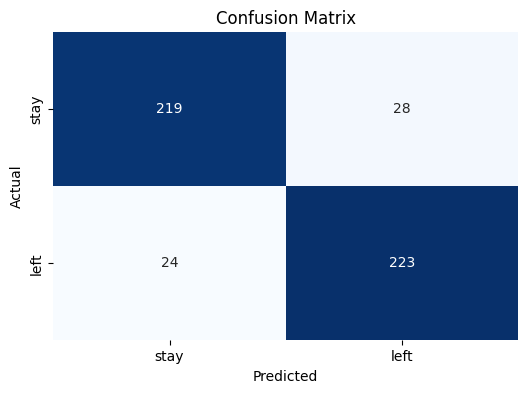

In [441]:
plot_confusion_matrix(y_test, y_pred_base)

The confusion matrix shows a detailed breakdown:

- True Positives (Predicted Left, Actual Left): 223
- True Negatives (Predicted Stay, Actual Stay): 219
- The model incorrectly missed 24 employees who left (False Negatives), which is a key error to minimize.

#### ROC Curve and AUC

Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) for the base model. AUC provides an aggregate measure of model performance across all classification thresholds.

Base Model ROC AUC: 0.966


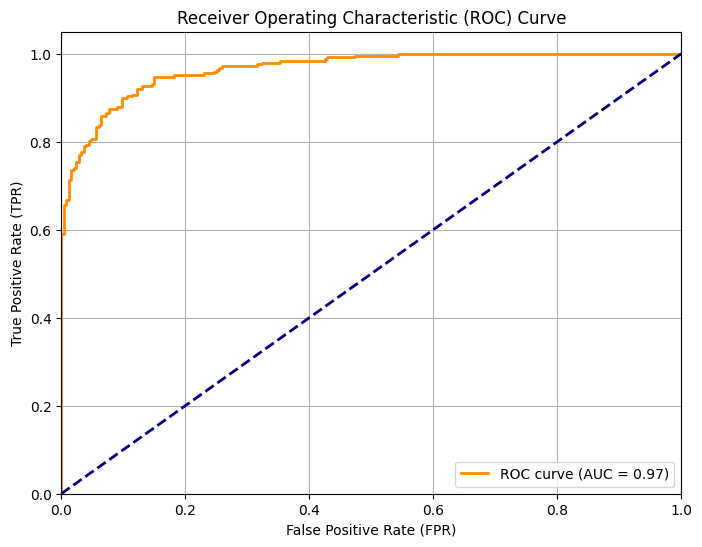

In [442]:
# ROC AUC Scores
roc_auc_base = auc(*roc_curve(y_test, y_pred_proba_base)[:2])

print(f"Base Model ROC AUC: {roc_auc_base:.3f}")

plot_roc_curve(y_test, y_pred_proba_base)

The ROC AUC score of 0.966 is excellent. A score this close to 1.0 indicates that the model has a very high capability to distinguish between employees who will leave and those who will stay. The curve's sharp bend towards the top-left corner visually confirms this strong discriminative power.

## Hyperparameter Tuning

We perform grid search cross-validation to optimize key XGBoost hyperparameters. The best model is selected based on ROC AUC score using 3-fold cross-validation on the training data.

In [443]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=3, 
                           verbose=1)

grid_search.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


The GridSearchCV process systematically tested numerous hyperparameter combinations and found this specific set to be optimal for maximizing the ROC AUC score. These parameters—a moderate learning rate, a controlled tree depth, and subsampling—suggest a final model that is regularized against overfitting and aims for robust generalization.

## Validation Set Evaluation (Tuned Model)

Evaluate the tuned XGBoost model on the validation set and print classification metrics to compare improvements over the base model.

In [444]:
# Use the best model from grid search
best_model = grid_search.best_estimator_

# Predictions
y_val_preds = best_model.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_preds))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       247
           1       0.92      0.90      0.91       246

    accuracy                           0.91       493
   macro avg       0.91      0.91      0.91       493
weighted avg       0.91      0.91      0.91       493



#### ROC AUC for Validation Set

Compute and print the ROC AUC for the base model on the validation set. 

In [445]:
# Predicted probabilities for the positive class 
y_pred_proba_val = xgb_model.predict_proba(X_val)[:, 1]

# ROC AUC Scores
roc_auc_val = auc(*roc_curve(y_val, y_pred_proba_val)[:2])

print(f"Base Model ROC AUC: {roc_auc_base:.3f}")

Base Model ROC AUC: 0.966


## Tuned Model: Test Set Evaluation

Apply the best-tuned XGBoost model to the holdout test set. Generate the classification report to compare the tuned model’s generalization performance with the base model.

In [446]:
best_model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [447]:
y_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

# Evaluate the model
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       247
           1       0.91      0.93      0.92       247

    accuracy                           0.92       494
   macro avg       0.92      0.92      0.92       494
weighted avg       0.92      0.92      0.92       494



#### Tuned Model Confusion Matrix

Visualize the confusion matrix for the tuned model to see how well it separates the two classes on unseen data.

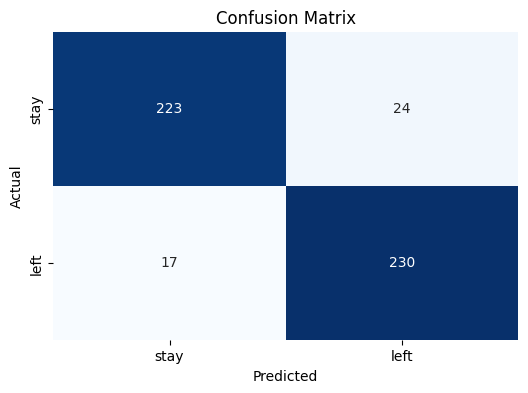

In [448]:
# Predicted probabilities for the positive class 
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test, y_pred_tuned)

The tuned model shows a clear improvement on the test set:

- Accuracy increased to 92% (from 89%).
- Recall for the 'left' class improved to 0.93 (from 0.90). This is the most significant business result, as the model is now better at its primary task of flagging at-risk employees.
- The number of False Negatives was reduced from 24 to 17, a direct and valuable improvement.

#### Tuned Model ROC Curve and AUC

Plot the ROC curve and print the AUC for the tuned model on the test set. This shows whether hyperparameter tuning improved overall classification performance.

Tuned Model ROC AUC: 0.969


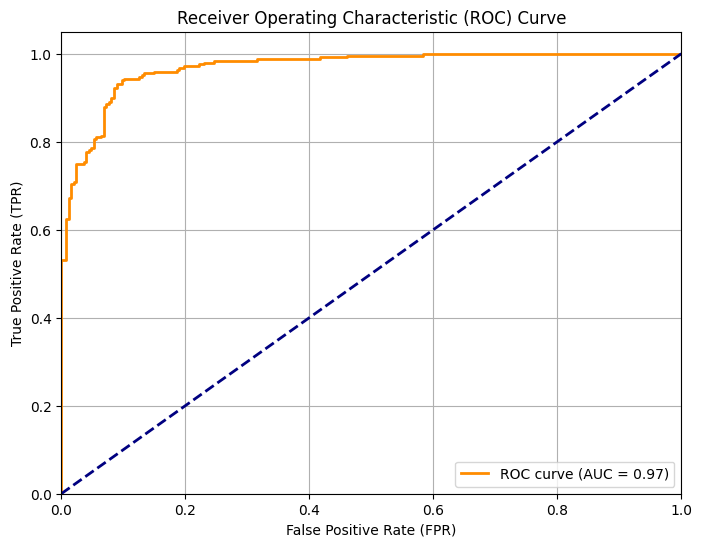

In [449]:
# ROC AUC Scores
roc_auc_tuned = auc(*roc_curve(y_test, y_pred_proba_tuned)[:2])

print(f"Tuned Model ROC AUC: {roc_auc_tuned:.3f}")

plot_roc_curve(y_test, y_pred_proba_tuned)

The ROC AUC score for the tuned model is 0.969, a slight but positive increase from the base model's 0.966, confirming its enhanced classification ability.

## Metric Comparison: Base vs. Tuned Model

Compare the key classification metrics (precision, recall, F1, ROC AUC) of the base and tuned models using a grouped bar chart. This visualizes the effectiveness of hyperparameter tuning.

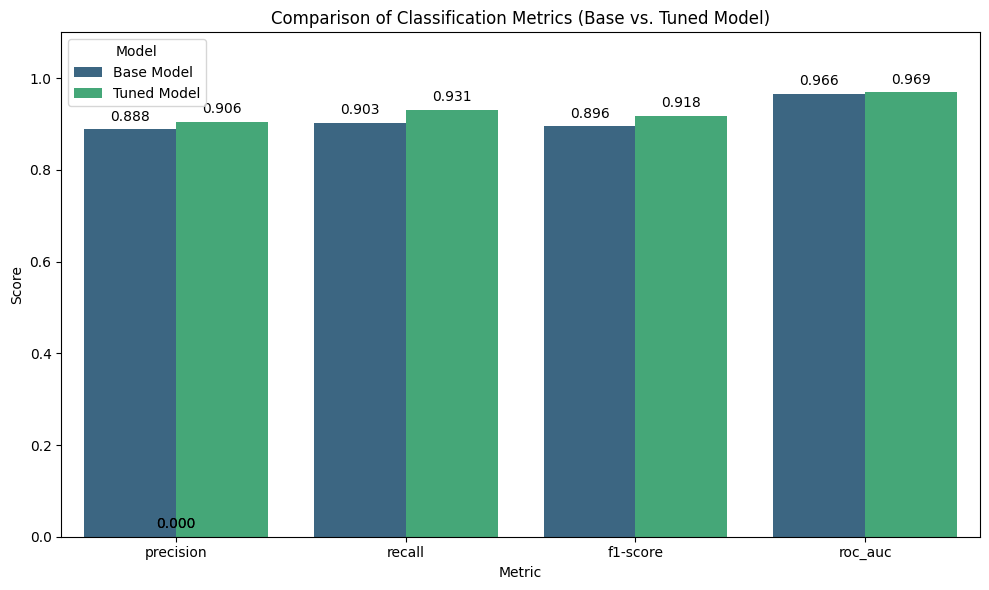

In [450]:
plot_metrics_comparison(report_base, report_tuned, roc_auc_base, roc_auc_tuned)

**Precision:** The precision score improved from 0.888 for the Base Model to 0.906 for the Tuned Model. This means that when the Tuned Model predicts a positive case, it is correct 90.6% of the time, making it more reliable in its positive predictions than the base model.

**Recall:** The recall score saw a significant increase from 0.903 to 0.931. This is a crucial improvement, indicating that the Tuned Model is better at identifying all actual positive cases, successfully capturing 93.1% of them compared to the base model's 90.3%.

**F1-Score:** Reflecting the improvements in both precision and recall, the F1-score rose from 0.896 to 0.918. As the harmonic mean of precision and recall, this higher score shows that the Tuned Model achieves a better overall balance between the two metrics.

**ROC AUC:** The ROC AUC (Area Under the Receiver Operating Characteristic Curve) score shows a slight improvement from 0.966 to 0.969. This indicates that the Tuned Model has a marginally better capability to distinguish between the positive and negative classes across all classification thresholds.

## Feature Importance

Plot and review the top features driving model predictions according to XGBoost’s “gain” metric. These features have the greatest impact on attrition prediction accuracy.

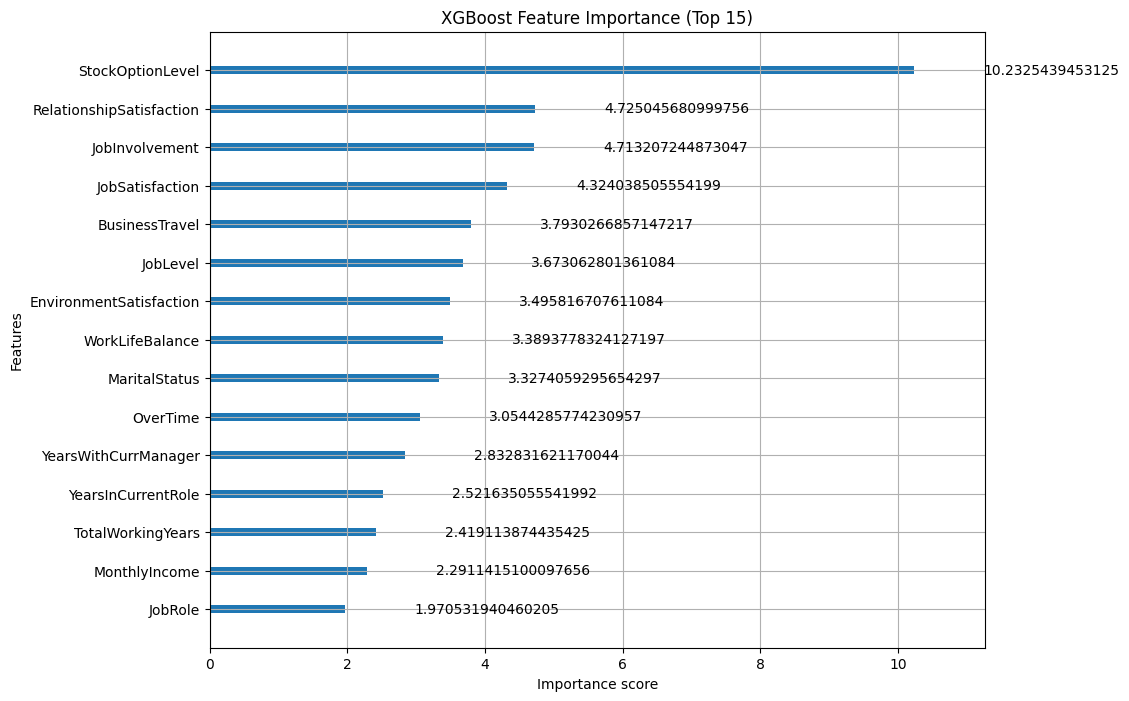

In [451]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(best_model, ax=ax, max_num_features=15, importance_type='gain')
plt.title('XGBoost Feature Importance (Top 15)')
plt.show()

#### Key Findings
**Dominant Predictor:** StockOptionLevel is overwhelmingly the most important feature, with an importance score of 10.23. This score is more than double that of the next most important feature, indicating that an employee's stock option level is the single most powerful predictor of attrition in your model.

**High-Tier Importance - Satisfaction Metrics:** 

Following StockOptionLevel, there is a cluster of features related to employee sentiment and engagement:

- RelationshipSatisfaction (Score: 4.72)
- JobInvolvement (Score: 4.71)
- JobSatisfaction (Score: 4.32) 

This shows that after equity, an employee's satisfaction with their work relationships, their level of involvement, and their overall job satisfaction are the next most critical factors.

**Mid-Tier Importance - Job & Work Environment:** This tier includes a mix of factors related to an employee's role, work conditions, and environment.

Factors like JobLevel, EnvironmentSatisfaction, WorkLifeBalance, MaritalStatus, and OverTime all have significant importance scores (ranging from ~3.0 to ~3.8). This indicates that an employee's seniority, their perception of the work environment, and their personal life all contribute meaningfully to the model's predictions.

**Lower-Tier Importance - Tenure & Income:** It is interesting to note that while still important enough to make the top 15, core HR metrics like TotalWorkingYears (2.42) and MonthlyIncome (2.29) have a lower relative importance compared to satisfaction and stock options. This suggests that while pay and experience matter, feelings of engagement and ownership (via stock options) are even stronger drivers in this model.

## Model Explainability: SHAP Values

Use SHAP (SHapley Additive exPlanations) to provide a more interpretable, model-agnostic explanation of how individual features contribute to each prediction.

In [452]:
shap.initjs()  # for interactive JS plots

# Create a TreeExplainer
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

#### SHAP Summary Bar Plot

Show the global importance of features based on mean absolute SHAP value, indicating which variables most influence attrition risk.

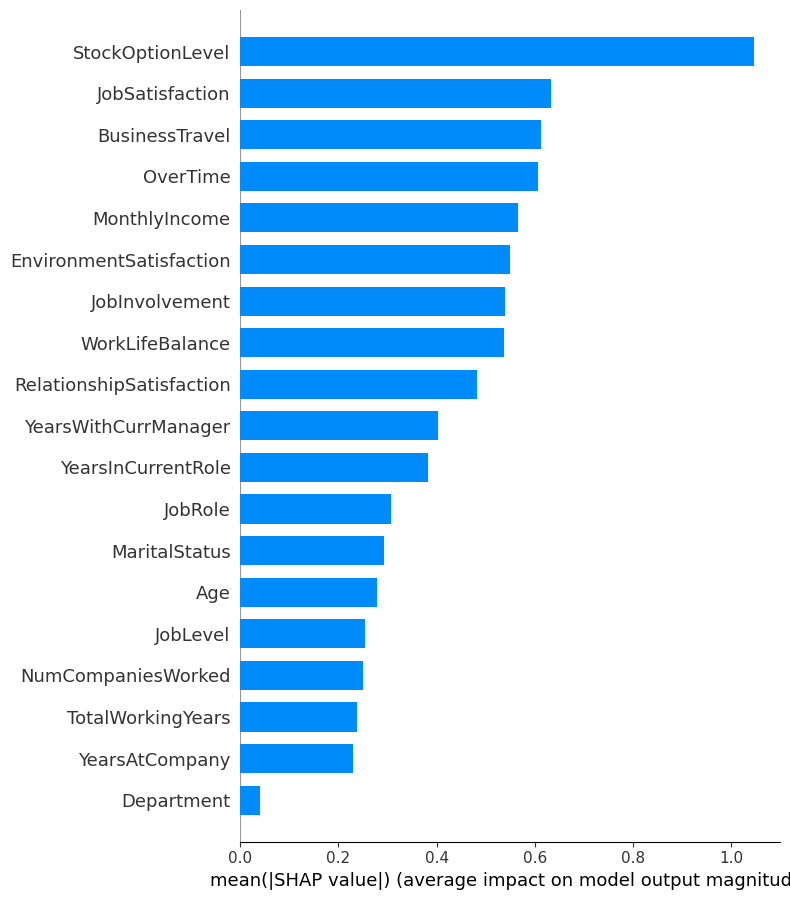

In [453]:
# Summary plot (bar): feature importance (mean(|SHAP value|))
shap.summary_plot(shap_values, X_test, plot_type="bar")

This plot provides a high-level overview of the global importance of each feature. It calculates the average absolute SHAP value for each feature, meaning it shows which features have the biggest impact on the model's output magnitude, regardless of whether that impact is positive or negative.

**Key Findings:**

**Most Influential Features:** The model's predictions are most heavily influenced by StockOptionLevel. This is followed by a group of important factors including JobSatisfaction, BusinessTravel, OverTime, and MonthlyIncome.

**Ranking:** The plot provides a clear ranking of the top features, confirming that employee equity, satisfaction, and work conditions are more impactful on the model's predictions than traditional demographic or tenure metrics like Age or TotalWorkingYears.

#### SHAP Beeswarm Plot

Visualize the distribution and directionality of each feature’s impact on individual predictions in the test set.

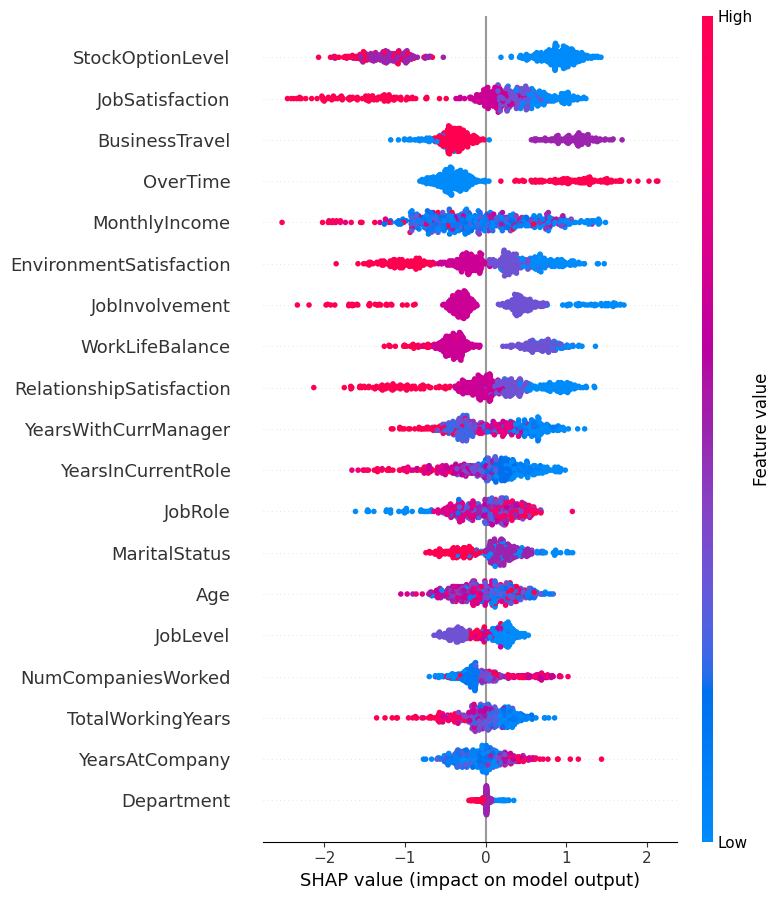

In [454]:
# Beeswarm plot: shows impact/direction for each feature and sample
shap.summary_plot(shap_values, X_test)

* **StockOptionLevel**: This is the most significant predictor.
    * **Observation**: Low values (blue dots) have high positive SHAP values, pushing predictions strongly towards attrition. High values (red dots) have negative SHAP values, indicating retention.
    * **Insight**: Having a low or zero stock option level is the single biggest factor driving the model to predict an employee will leave.

* **JobSatisfaction**:
    * **Observation**: A clear separation is visible. Low satisfaction (blue dots) leads to positive SHAP values, while high satisfaction (red dots) leads to negative SHAP values.
    * **Insight**: Dissatisfied employees are at a high risk of leaving, and this is a major factor in the model's decision-making.

* **BusinessTravel**:
    * **Observation**: There is a dense cluster of red dots (indicating frequent travel) on the positive side of the SHAP value axis.
    * **Insight**: Frequent business travel is a strong predictor of attrition.

* **OverTime**:
    * **Observation**: High values for overtime (red dots) are almost exclusively on the right side, pushing the prediction towards attrition.
    * **Insight**: Working overtime is a clear and significant driver of an employee's likelihood to leave.

* **MonthlyIncome**:
    * **Observation**: Low income (blue dots) pushes the prediction higher (positive SHAP value), while high income (red dots) pushes it lower (negative SHAP value).
    * **Insight**: Lower monthly income is a key factor that increases the predicted risk of attrition.

In [455]:
import joblib

# Model name
model_filename = "../resources/models/xgboost_attrition_model.joblib"

# Save the model to the specified file
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ../resources/models/xgboost_attrition_model.joblib



## Conclusion

#### 1. The Model is Highly Effective

Based on a comprehensive evaluation, the tuned XGBoost model is a **highly effective and reliable tool for predicting employee attrition.**

* It achieves an excellent **ROC AUC score of 0.969**, demonstrating a strong ability to distinguish between employees who will leave and those who will stay.
* More importantly, it has a **Recall of 0.931 for the "left" class**. This is a particularly valuable business outcome, as it means the model successfully identifies **93% of all employees who are actually at risk of leaving**, minimizing the chance of missing a flight risk. The successful hyperparameter tuning was justified by the consistent improvement across all metrics compared to the base model.

#### 2. Key Drivers of Attrition

Beyond its predictive accuracy, the model provides clear, actionable insights into *why* employees are leaving. The Feature Importance and SHAP analyses consistently highlight three primary themes:

* **Financial & Career Stagnation is the Strongest Driver:**
    * The analysis from all plots overwhelmingly identifies `StockOptionLevel` as the single most powerful predictor. The SHAP plot clearly shows that a **low or zero stock option level** dramatically increases the predicted risk of attrition.
    * This is strongly supported by `MonthlyIncome` and `JobLevel`, where lower incomes and junior job levels also significantly push the prediction towards an employee leaving.

* **Work Environment and Burnout are Critical Factors:**
    * `JobSatisfaction` and `OverTime` are ranked as top-tier predictors.
    * The SHAP plot reveals a clear trend: employees working **overtime** and those with **low job satisfaction** have a much higher likelihood of leaving. This points directly to burnout and a negative daily work experience as major factors.

* **Engagement and Relationships Matter:**
    * Features like `RelationshipSatisfaction` and `JobInvolvement` also rank highly. This shows that an employee's connection to their colleagues, manager, and their sense of involvement in their work are meaningful factors in their decision to stay or leave.

#### 3. Actionable Recommendations

Synthesizing these insights leads to clear, data-driven recommendations for the HR department to improve employee retention:

1.  **Prioritize Equity and Compensation Review**: Given that `StockOptionLevel` is the dominant factor, the most impactful retention strategy would be to **review and potentially expand the employee stock option program**, especially for those in lower job levels or salary bands who currently have little to no participation.

2.  **Address Work-Life Balance and Culture**: The strong signal from `OverTime` and various satisfaction metrics suggests an urgent need to **manage employee workload and address the root causes of low job satisfaction**. This could involve workload audits, manager training, and targeted cultural initiatives to improve the work environment.

3.  **Implement a Proactive Retention Program**: This model should be used as a proactive tool. By running employee data through the model, HR can identify individuals with a high-risk profile (e.g., low stock options, low satisfaction, working overtime) and engage them with **targeted retention efforts**—such as career path discussions or compensation reviews—*before* they become a flight risk.